In [40]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence
from datetime import datetime

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

from typing import Tuple
import jax
import jax.numpy as jnp
import flax.linen as nn

import matplotlib.pyplot as plt



from flax.training import checkpoints
from pathlib import Path

import warnings

# Suppress specific Orbax sharding warning
warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "./data"
model_dir = "./models"
model_prefix = "rbm_amp_202506031229_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : ./data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506031229_0


In [41]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
import re
from typing import Tuple

class MultiBasisDataLoader:
    """
    Takes a dict[str, jnp.ndarray] where each key is a basis string
    (e.g. "XZYX…") and each value is an array of shape (total_samples, n_visible).
    On iteration, yields batches of size B—but in the form:
      (basis_ids, batch_array)
    where
      basis_ids:  jnp.int8 array of shape (N_B, n_visible)
      batch_array: jnp.float32 array of shape (N_B, B, n_visible)

    This lets you feed the output directly into:
      model.apply(..., (basis_ids, batch_array))
    """
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        # Verify all arrays have the same total length
        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        # Keep insertion order of keys (Python 3.7+ guarantees dict preserves insertion order)
        self._bases = list(data_dict.keys())          # order of basis strings
        self._arrays = list(data_dict.values())       # corresponding jnp.ndarray

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        # Pre‐encode basis strings → integer arrays of shape (n_visible,)
        #   where Z→0, X→1, Y→2
        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        # Precompute slice indices for one epoch
        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        # Gather the correct slice for each basis‐array
        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        # Now stack:
        #   data_array: shape (N_B, batch_size, n_visible)
        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [42]:
data_dict = load_measurements("data/", "w_*.txt")
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [46]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

        #SQRT2 = jnp.sqrt(2.0)
        #self.rotators = {
        #    1: jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2,   # X
        #    2: jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / SQRT2  # Y
        #}

    def __call__(self, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        basis_array, data_array = data_tuple  # (N_B, n_visible), (N_B, B, n_visible)
        loss_sums = jax.vmap(self._rotated_log_prob_loss)(data_array, basis_array)

        per_basis_mean = loss_sums / data_array.shape[1]
        return jnp.sum(per_basis_mean)

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    def _rotated_log_prob_loss(self, data: jnp.ndarray, basis_ids: jnp.ndarray) -> jnp.ndarray:
        B, n = data.shape
        non_z = jnp.nonzero(basis_ids != 0, size=2, fill_value=-1)[0]
        j, k = non_z[0], non_z[1]
        b1, b2 = basis_ids[j], basis_ids[k]

        SQRT2 = jnp.sqrt(2.0)
        rot_X = jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2
        rot_Y = jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / SQRT2

        Rj = jax.lax.switch(b1 - 1, [lambda: rot_X, lambda: rot_Y])
        Rk = jax.lax.switch(b2 - 1, [lambda: rot_X, lambda: rot_Y])
        U = jnp.kron(Rj, Rk)

        # get 4x4 rotation matrix
        #U = jnp.kron(self.rotators[b1], self.rotators[b2])  # (4, 4)
        combos = jnp.array([[0.,0.],[0.,1.],[1.,0.],[1.,1.]], dtype=data.dtype)  # (4, 2)

        sigma_b_tiled = jnp.tile(data[:, None, :], (1, 4, 1))  # (B, 4, n)
        sigma_mod = sigma_b_tiled.at[:, :, [j, k]].set(combos[None, :, :])  # (B, 4, n)
        sigma_flat = sigma_mod.reshape(B * 4, n)  # (4B, n)

        F_amp = self._free_energy_amp(sigma_flat).reshape(B, 4)
        F_pha = self._free_energy_pha(sigma_flat).reshape(B, 4)

        log_mag = -0.5 * F_amp
        angle   = -0.5 * F_pha
        M = jnp.max(log_mag, axis=1, keepdims=True)
        scaled = jnp.exp(log_mag - M + 1j * angle)  # (B, 4)

        idx_in = (data[:, j].astype(int) << 1) | data[:, k].astype(int)  # (B,)
        U_cols = U[:, idx_in].T  # (B, 4)

        S_prime = jnp.sum(U_cols * scaled, axis=1)  # (B,)
        log_probs = 2.0 * (M.squeeze() + jnp.log(jnp.abs(S_prime) + 1e-12))  # (B,)

        return -jnp.sum(log_probs)

In [50]:
import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
from typing import Tuple, Dict, Any

# ---------------------------------------------------------------------
# 1.  one JIT-compiled phase-training step
# ---------------------------------------------------------------------
@jax.jit
def train_step_pha(
        state: TrainState,                              # holds phase params + opt state
        amp_vars: Dict[str, jnp.ndarray],               # frozen amplitude vars
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray]     # (basis_ids, data_array)
) -> Tuple[TrainState, jnp.ndarray]:
    """
    data_tuple:
      basis_ids  – jnp.int8  (N_B, n_visible)
      data_array – jnp.float32 (N_B, B, n_visible)
    """

    # loss(params) = model.apply({'params': params, 'amp': amp_vars}, data_tuple)
    def loss_fn(params):
        variables = {'params': params, 'amp': amp_vars}
        return state.apply_fn(variables, data_tuple)   # PairPhaseRBM returns scalar loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state   = state.apply_gradients(grads=grads)
    return new_state, loss


# ---------------------------------------------------------------------
# 2.  full training loop over epochs
# ---------------------------------------------------------------------
def train_phase_rbm(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",   # yields (basis_ids, data_array)
        num_epochs: int,
        *,
        quiet: bool = False
) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_pha(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(
            loss=avg_loss,
        )

        if not quiet:
            print(f"Epoch {epoch+1}/{num_epochs} │ Loss_: {avg_loss:.4f}")

    return state, metrics

In [ ]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [56]:
batch_size    = 64
visible_units = 10
hidden_units  = 16
num_epochs    = 30
init_lr       = 1e-3

key   = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_basis  = jnp.zeros((1, visible_units), dtype=jnp.int8)
dummy_data   = jnp.zeros((1, batch_size, visible_units), dtype=jnp.float32)
vars_pha = model_pha.init(key, (dummy_basis, dummy_data))

optim = optax.adam(init_lr)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha  = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

state_pha, metrics_pha = train_phase_rbm(
    state_pha,
    amp_vars=amp_vars,
    loader  = loader_pha,
    num_epochs=num_epochs
)

Epoch 1/30 │ Loss_: -80.8872
Epoch 2/30 │ Loss_: -84.2034
Epoch 3/30 │ Loss_: -85.1674
Epoch 4/30 │ Loss_: -85.5544
Epoch 5/30 │ Loss_: -85.7106
Epoch 6/30 │ Loss_: -85.7803
Epoch 7/30 │ Loss_: -85.8210
Epoch 8/30 │ Loss_: -85.8524
Epoch 9/30 │ Loss_: -85.8810
Epoch 10/30 │ Loss_: -85.9088
Epoch 11/30 │ Loss_: -85.9362
Epoch 12/30 │ Loss_: -85.9629
Epoch 13/30 │ Loss_: -85.9888
Epoch 14/30 │ Loss_: -86.0140
Epoch 15/30 │ Loss_: -86.0378
Epoch 16/30 │ Loss_: -86.0603
Epoch 17/30 │ Loss_: -86.0814
Epoch 18/30 │ Loss_: -86.1005
Epoch 19/30 │ Loss_: -86.1185
Epoch 20/30 │ Loss_: -86.1348
Epoch 21/30 │ Loss_: -86.1487
Epoch 22/30 │ Loss_: -86.1615
Epoch 23/30 │ Loss_: -86.1726
Epoch 24/30 │ Loss_: -86.1819
Epoch 25/30 │ Loss_: -86.1895
Epoch 26/30 │ Loss_: -86.1957
Epoch 27/30 │ Loss_: -86.2009
Epoch 28/30 │ Loss_: -86.2046
Epoch 29/30 │ Loss_: -86.2086
Epoch 30/30 │ Loss_: -86.2106


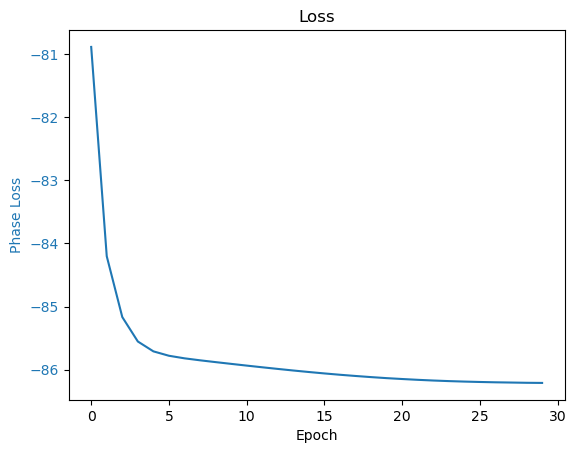

In [57]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()